In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, alias, desc

In [6]:
#Creating engine using hawaii.sqlite database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Exploratory Climate Analysis

* Design a query to retrieve the last 12 months of precipitation data and plot the results

* Calculate the date 1 year ago from the last data point in the database

* Perform a query to retrieve the data and precipitation scores

* Save the query results as a Pandas DataFrame and set the index to the date column

* Sort the dataframe by date

* Use Pandas Plotting with Matplotlib to plot the data


In [12]:
latest_date = session.query(Measurement.date).\
              order_by(Measurement.date.desc()).first()
latest = dt.date(2017,8,23)
print(latest)

2017-08-23


In [13]:
date_yr = dt.date(2017,8,23) - dt.timedelta(days=365)
date_yr

datetime.date(2016, 8, 23)

In [14]:
results = session.query(Measurement.date,Measurement.prcp).\
          filter(Measurement.date > date_yr).\
          order_by(Measurement.date.desc()).all()

prcp_df = pd.DataFrame(results, columns=['Date','Precipitation'])
prcp_df = prcp_df.set_index('Date')

prcp_df = prcp_df.sort_values(by=['Date'],ascending=True)

prcp_df.to_csv('prcp.csv')
prcp_df.head()

,Precipitation
Date,
2016-08-24,1.45
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.15
2016-08-24,NaN


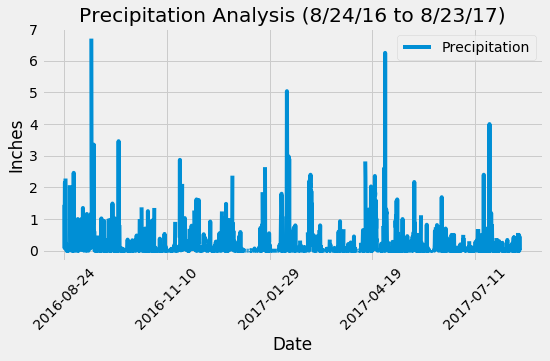

In [15]:
ax = prcp_df.plot(figsize=(8,4), rot=45)
ax.set_title("Precipitation Analysis (8/24/16 to 8/23/17)")
ax.set_ylabel('Inches')
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [18]:
# Design a query to show how many stations are available in this dataset?

#session.query(func.count(distinct(Measurement.station))).all()

session.query(func.count(Station.station)).all()

[(9)]

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(desc(func.count(Measurement.station))).\
all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station=='USC00519281').all()

[(85.0, 54.0, 71.66378066378067)]

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_observation = session.query(Measurement.station,Measurement.tobs,Measurement.date).filter(Measurement.station=='USC00519281').\
filter(Measurement.date > date_yr).all()

temp_df = pd.DataFrame(temp_observation, columns=['Station','Temperature','Date'])
temp_df.head()

,Station,Temperature,Date
0,USC00519281,77.0,2016-08-24
1,USC00519281,80.0,2016-08-25
2,USC00519281,80.0,2016-08-26
3,USC00519281,75.0,2016-08-27
4,USC00519281,73.0,2016-08-28


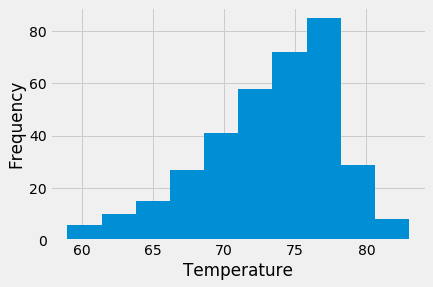

In [22]:
plt.hist(temp_df['Temperature'], density=False)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        "end_date (string): A date string in the format %Y-%m-%d"
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28','2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
 53.0, 
    73.09795396419437, 
    87.0
    
    .filter(Measurement.date <= end_date)

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
